In [1]:
import pandas as pd
import numpy as np

In [15]:
datar = pd.read_csv('data/rawdata/2016r.txt',sep=';')
datar.columns = np.array([str(i).strip().replace(' ','_') for i in list(datar.columns.values)])
datar = datar[['Tournament_Year','Tournament_#','Permanent_Tournament_#','Course_#','Player_Number','Player_Name','Round_Number',
               'Tee_Time','Round_Score','End_of_Event_Pos._(text)']]

In [11]:
datar.tail()

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text)
17538,2016,470,27,689,35545,"Barber, Blayne",4,12:30,75,T41
17539,2016,470,27,689,36689,"Koepka, Brooks",4,08:20,73,T70
17540,2016,470,27,689,37189,"Varner III, Harold",4,10:30,75,T60
17541,2016,470,27,689,40026,"Berger, Daniel",4,08:40,74,T70
17542,2016,470,27,689,40058,"Blair, Zac",4,07:40,73,T74


In [17]:
from collections import defaultdict
d = defaultdict(list)
for tup,df in datar.groupby(['Player_Number','Permanent_Tournament_#']): 
    d['Player_Number'].append(df.iloc[0].Player_Number)
    d['Permanent_Tournament_Number'].append(df.iloc[0]['Permanent_Tournament_#'])
    for r in range(1,7):
        try:
            d['Round_%d_Score' % r].append(df[df.Round_Number==r].Round_Score.values[0])
        except:
            d['Round_%d_Score' % r].append(np.nan)
    d['Total_Strokes'].append(df.Round_Score.sum())

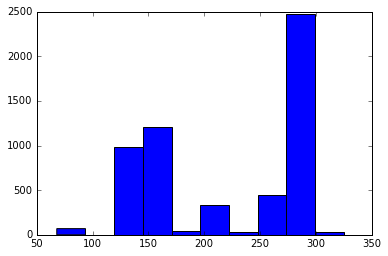

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(pd.DataFrame(d).Total_Strokes);

In [18]:
datae = pd.DataFrame(d)

In [19]:
def make_finishing_pos(m):
    A = pd.DataFrame(m).transpose()
    A.columns = ['End_of_Event_Pos._(text)','Total_Strokes','Round_1_Score','Round_2_Score','Round_3_Score','Round_4_Score',
                'Round_5_Score','Round_6_Score']

    A.loc[A[A['End_of_Event_Pos._(text)']=='1'].index,'Total_Strokes'] -= 1

    A.insert(len(A.columns),'ranked',np.zeros(len(A)))
    A = A.sort_values('Total_Strokes',ascending=False)
    rank_of_everyone = np.array([])
    for r in range(6,1,-1):
        to_be_ranked = A[(A['Round_%d_Score' % (r,)].notnull()) & (A.ranked!=1)]
#         print to_be_ranked
        rank = to_be_ranked.rank(axis=0).Total_Strokes.values + len(rank_of_everyone[np.where(rank_of_everyone!=0)])
        rank_of_everyone = np.append(rank_of_everyone,rank)
        A.loc[to_be_ranked.index,'ranked'] = 1
    A.insert(len(A.columns),'Finishing_Pos',rank_of_everyone)
    return {player:A[A.index==player].Finishing_Pos.values.tolist()[0] for player in A.index}

In [20]:
def make_df(year,datae,datar):

    datar.columns = np.array([str(i).strip().replace(' ','_') for i in list(datar.columns.values)])
    datae.columns = np.array([str(i).strip().replace(' ','_') for i in list(datae.columns.values)])

    datar = datar[['Tournament_Year','Tournament_#','Permanent_Tournament_#','Course_#','Player_Number','Player_Name','Round_Number',
                'Tee_Time','Round_Score','End_of_Event_Pos._(text)']]
    datae = datae[['Permanent_Tournament_Number','Player_Number','Total_Strokes','Round_1_Score','Round_2_Score','Round_3_Score','Round_4_Score',
                'Round_5_Score','Round_6_Score']]
    datae.columns = [['Permanent_Tournament_#','Player_Number','Total_Strokes','Round_1_Score','Round_2_Score','Round_3_Score','Round_4_Score',
                'Round_5_Score','Round_6_Score']]

    data = datar.merge(datae,'left',on=['Permanent_Tournament_#','Player_Number'])
    data['End_of_Event_Pos._(text)'] = data['End_of_Event_Pos._(text)'].str.strip()
    
    inds_to_drop = set(data[data['End_of_Event_Pos._(text)'].isin(['W/D','DQ'])].index.tolist())
    inds_to_drop.update(data[data.Total_Strokes==0].index.tolist())
    inds_to_drop.update(data[data.Round_1_Score==0].index.tolist())
    inds_to_drop.update(data[data.Round_2_Score==0].index.tolist())
    inds_to_drop.update(data[(data.Round_3_Score!=0) & (data.Round_3_Score<55)].index.tolist())
    inds_to_drop.update(data[(data.Round_4_Score!=0) & (data.Round_4_Score<55)].index.tolist())
    inds_to_drop.update(data[(data.Round_5_Score!=0) & (data.Round_5_Score<55)].index.tolist())
    inds_to_drop.update(data[(data.Round_6_Score!=0) & (data.Round_6_Score<55)].index.tolist())
    inds_to_drop = pd.Index(inds_to_drop)
    data = data.drop(inds_to_drop,axis=0)

    assert np.sum(data['Tournament_#'] == data.sort_values('Tournament_#')['Tournament_#']) == len(data)

    tournaments = pd.unique(data['Tournament_#'])
    for u,t in enumerate(tournaments):
        subset = data[data['Tournament_#']==t]
        finishing_pos_map = {player:subset[subset.Player_Number==player][['End_of_Event_Pos._(text)','Total_Strokes','Round_1_Score','Round_2_Score',
        'Round_3_Score','Round_4_Score','Round_5_Score','Round_6_Score']].values[0,:].tolist() for player in pd.unique(subset.Player_Number)}
        finishing_pos_map = make_finishing_pos(finishing_pos_map)
        subset = subset.drop(['Total_Strokes','Round_1_Score','Round_2_Score','Round_3_Score','Round_4_Score','Round_5_Score','Round_6_Score'],axis=1)
        subset.insert(len(subset.columns),'Finishing_Pos',[finishing_pos_map[player] for player in subset.Player_Number])
        subset.insert(len(subset.columns),'Finishing_Pct',subset.rank(pct=True).Finishing_Pos)
        if u==0:
            newdata = subset
        else:
            newdata = newdata.append(subset)

    return newdata

In [21]:
newdata = make_df(2016,datae,datar)

In [23]:
newdata.tail(30)

,Tournament_Year,Tournament_#,Permanent_Tournament_#,Course_#,Player_Number,Player_Name,Round_Number,Tee_Time,Round_Score,End_of_Event_Pos._(text),Finishing_Pos,Finishing_Pct
17513,2016,470,27,689,30925,"Johnson, Dustin",4,13:00,73,T18,19.5,0.195153
17514,2016,470,27,689,30944,"Kokrak, Jason",4,12:50,69,T7,8.0,0.077806
17515,2016,470,27,689,31202,"McGirt, William",4,08:10,67,T41,44.0,0.445153
17516,2016,470,27,689,31323,"Woodland, Gary",4,13:20,69,T4,5.0,0.047194
17517,2016,470,27,689,31416,"Fathauer, Derek",4,09:50,69,T31,35.5,0.358418
17518,2016,470,27,689,31557,"Herman, Jim",4,11:20,71,T22,26.0,0.261480
17519,2016,470,27,689,31560,"Stuard, Brian",4,11:40,73,T41,44.0,0.445153
17520,2016,470,27,689,31646,"Grillo, Emiliano",4,13:30,69,T2,2.5,0.021684
17521,2016,470,27,689,32102,"Fowler, Rickie",4,13:50,74,T7,8.0,0.077806
17522,2016,470,27,689,32366,"Chappell, Kevin",4,10:10,70,T31,35.5,0.358418


In [24]:
newdata.to_csv('2016r.csv',index=False)